In [0]:
pip install mlflow

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
pip install imblearn

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
pip install xgboost

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# Databricks notebook source
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score

In [0]:
# create SparkSession
spark = SparkSession.builder.appName("Data").getOrCreate()

In [0]:
# Load the dataset
df = spark.read.csv("/FileStore/tables/customer_booking.csv", header=True, inferSchema=True)

In [0]:
# Converting Spark DataFrame to Pandas DataFrame for Machine Learning 
data = df.toPandas()

In [0]:
# Data overview
print(data.info())  # Check data types and missing values
print(data.describe())  # Check data types and missing values
print(data.head())  # Check data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int32  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int32  
 4   length_of_stay         50000 non-null  int32  
 5   flight_hour            50000 non-null  int32  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int32  
 10  wants_preferred_seat   50000 non-null  int32  
 11  wants_in_flight_meals  50000 non-null  int32  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int32  
dtypes: float64(1), int32(8), object(5)
memory usage: 3.8+ 

In [0]:
# Check categorical variables
categorical_columns = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']

# Use One-Hot coding
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Confirmation of post-coding data
print(data.head())

   num_passengers  purchase_lead  length_of_stay  flight_hour  \
0               2            262              19            7   
1               1            112              20            3   
2               2            243              22           17   
3               1             96              31            4   
4               2             68              22           15   

   wants_extra_baggage  wants_preferred_seat  wants_in_flight_meals  \
0                    1                     0                      0   
1                    0                     0                      0   
2                    1                     1                      0   
3                    0                     0                      1   
4                    1                     0                      1   

   flight_duration  booking_complete  sales_channel_Mobile  ...  \
0             5.52                 0                     0  ...   
1             5.52                 0            

In [0]:
# Select columns to be standardized
numeric_columns = ['purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']

# Standardized
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

print(data[numeric_columns].head())

   purchase_lead  length_of_stay  flight_hour  flight_duration
0       1.957530       -0.119353    -0.381764        -1.174175
1       0.299164       -0.089844    -1.120780        -1.174175
2       1.747470       -0.030824     1.465775        -1.174175
3       0.122272        0.234761    -0.936026        -1.174175
4      -0.187290       -0.030824     1.096267        -1.174175


In [0]:
# Extract features and target variables
X = data.drop('booking_complete', axis=1)
y = data['booking_complete']

# Delineate training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Test Set Size: {X_test.shape}")

Training set size: (40000, 918), Test Set Size: (10000, 918)


In [0]:
# 2. Data balancing: applying SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      8520
           1       0.35      0.42      0.38      1480

    accuracy                           0.80     10000
   macro avg       0.62      0.64      0.63     10000
weighted avg       0.82      0.80      0.81     10000

AUC Score: 0.7622247335363533


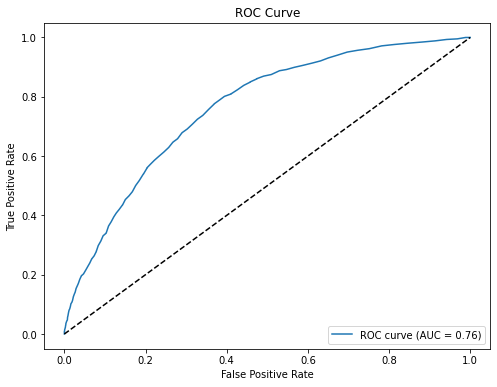

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


# 3. Model training: random forest with weights
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train_sm, y_train_sm)

# 4. Model predictions
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# 5. Assessment of model performance
classification_rep = classification_report(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_prob)

print("Classification report:")
print(classification_rep)
print("AUC Score:", auc_score)

# 6. plotting ROC curves
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [0]:
# Step 5: Initialize Logistic Regression model
logreg = LogisticRegression(random_state=42)

# Step 6: Train the model on the balanced training data
logreg.fit(X_train_sm, y_train_sm)

# Step 7: Predict on the test set
y_pred = logreg.predict(X_test)

# Step 8: Evaluate the model
print("model accuracy: ", accuracy_score(y_test, y_pred))
print("Classification report: \n", classification_report(y_test, y_pred))

model accuracy:  0.7768
Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.82      0.86      8520
           1       0.33      0.51      0.40      1480

    accuracy                           0.78     10000
   macro avg       0.62      0.67      0.63     10000
weighted avg       0.82      0.78      0.79     10000



/databricks/python/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
